# Experiment by varying number of nodes

In [1]:
import numpy as np
from numpy.random import normal, poisson
import argparse
from collections import Counter
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import scale
from scipy.stats import chi2, norm
from sklearn.metrics import adjusted_rand_score as ari
!pip install graspologic
import graspologic
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.cluster import AutoGMMCluster
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial

C:\Users\16827\miniconda3\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [4]:
#Code provided by Passino et al.
## Takes a vector and returns its spherical coordinates
def cart_to_sphere(x):
    ## theta_1
    q = np.arccos(x[1] / np.linalg.norm(x[:2]))
    sphere_coord = [q] if x[0] >= 0 else [2*np.pi - q]
    ## Loop for theta_2, ..., theta_m-1
    for j in range(2,len(x)):
      sphere_coord += [2 * np.arccos(x[j] / np.linalg.norm(x[:(j+1)]))]
    ## Return the result in a numpy array
    return np.array(sphere_coord)

## Takes a matrix and returns the spherical coordinates obtained along the given axis
def theta_transform(X,axis=1):
    ## Apply the function theta_transform along the axis
    return np.apply_along_axis(func1d=cart_to_sphere, axis=axis, arr=X)

In [5]:
def plot_latent(X, zz, method = None, pred = False, scale=4):
  fig, ax = plt.subplots(1, X.shape[1], figsize=(scale * X.shape[1], scale * 1))
  if method == 'theta':
    indices = [(i, i+1) if i != 1 else (i-(X.shape[1]-1),i)for i in range(X.shape[1])]
    variable_name = "\Theta"
    msg = "spherical coordinates on unit circle"
  elif method == 'normalised':
    indices = [(i, i+1) if i != 2 else (i-(X.shape[1]-1),i)for i in range(X.shape[1])]
    variable_name = "\overline{X}"
    msg = "projections on unit circle"
  else:
    indices = [(i, i+1) if i != 2 else (i-(X.shape[1]-1),i)for i in range(X.shape[1])]
    variable_name = "X"
    msg = "no transformation"

  legend = ["Community "+str(z+1) for z in zz]

  for i in range(X.shape[1]):
        xlabel = r"$\mathbf{" + variable_name + "}_"+str(indices[i][0]) + "$"
        ylabel = r"$\mathbf{" + variable_name + "}_"+str(indices[i][1]) + "$"

        x_hist = {xlabel: X[:, indices[i][0]], ylabel: X[:, indices[i][1]], 'labels': legend}

        x_hist = pd.DataFrame(data=x_hist)
        sns.scatterplot(data=x_hist, x=xlabel,y = ylabel, hue="labels", palette= "tab10", ax = ax[i], edgecolors=None, linewidth=0, alpha = 0.7, s=10)
        ax[i].set(xlabel=xlabel, ylabel=ylabel)
        ax[i].axis('equal')
        if i == X.shape[1]-1:
          ax[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        else:
          ax[i].get_legend().remove()
  fig.subplots_adjust(hspace=10)
  if pred:
    fig.suptitle(r"GMM predictions on Latent Positions using "+msg)
  else:
    fig.suptitle(r"Latent Positions using "+msg)

def plot_beta(ax, a, b):
  def beta_pdf(x,a,b):
    return ((gamma(a+b))/(gamma(a)*gamma(b)))*(x**(a-1))*((1-x)**(b-1))
  x = np.array(range(0,101))/100
  beta_pdf = np.apply_along_axis(lambda inp: beta_pdf(inp, a, b), axis=0, arr=x)
  ax.plot(x, beta_pdf)
  ax.set(xlabel='Value', ylabel='Probability', title='Degree correction parameters pdf')
def plot_hist_dc(rho, ax):
  ax.hist(x=rho, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
  ax.set(xlabel='Value', ylabel='Frequency', title='Degree correction parameters histogram')

def compare_ARIs(B, n = 1000, M_sim = 25, K = 3, beta_params = (2,1), seed = 14441):
  ## Set seed to repeat the simulation
  np.random.seed(seed)
  q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
  z = np.zeros(n,dtype=int)
  for k in range(K):
      z[q[k]:] = k
  
  n_com_1000 = []
  n_com_norm_1000 = []
  n_com_theta_1000 = []

  ari_com_1000 = []
  ari_com_norm_1000 = []
  ari_com_theta_1000 = []

  scale = 4
  fig1, axis1 = plt.subplots(1, 2, figsize=(scale * 2, scale * 1))
  fig1.tight_layout(pad=5.0)

  plot_beta(axis1[0], a=beta_params[0],b=beta_params[1])

  rho = np.random.beta(a=beta_params[0],b=beta_params[1],size=n)
  plot_hist_dc(rho, axis1[1])


  ## Repeat M_sim times
  for s in range(M_sim):
      print(s)
      rho = np.random.beta(a=beta_params[0],b=beta_params[1],size=n)
      if s==0:
        plot_hist_dc(rho, axis1[1])

      ## Construct the adjacency matrix
      A = np.zeros((n,n))
      for i in range(n-1):
          for j in range(i+1,n):
              edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
              A[i,j] = edge
              A[j,i] = edge
      
      ## Obtain the embeddings
      ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
      X = ase.fit_transform(A)

      #removes latent positions made up only by zeros
      idx_zerorows = np.where(~X.any(axis=1))
      X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
      zz = np.delete(z, idx_zerorows, 0) 

      if s ==0:
        plot_latent(X, zz, method = None, pred = False)

      #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
      M = AutoGMMCluster(min_components=2, max_components=7)
      for t in [None, 'normalised', 'theta']:
        if t == 'normalised':
            X_norm = normalize(X)
            if s ==0:
              plot_latent(X_norm, zz, method = t, pred = False)
            M.fit(X_norm, y=zz)
            if s ==0:
              zz_hat = M.model_.predict(X_norm) # Incorporate zz_hat into plot_latent
              plot_latent(X_norm, zz_hat, method = t, pred = True)
            n_com_norm_1000.append(M.n_components_)
            ari_com_norm_1000.append(M.ari_)
        elif t == 'theta':
            X_theta = theta_transform(X)
            if s ==0:
              plot_latent(X_theta, zz, method = t, pred = False)
            M.fit(X_theta, y=zz)
            if s ==0:
              zz_hat = M.model_.predict(X_theta)
              plot_latent(X_theta, zz_hat, method = t, pred = True)
            n_com_theta_1000.append(M.n_components_)
            ari_com_theta_1000.append(M.ari_)
        else:
            M.fit(X, y=zz)
            if s ==0:
              zz_hat = M.model_.predict(X)
              plot_latent(X, zz_hat, method = t, pred = True)
            n_com_1000.append(M.n_components_)
            ari_com_1000.append(M.ari_)

  return ([n_com_1000, n_com_norm_1000, n_com_theta_1000], [ari_com_1000, ari_com_norm_1000, ari_com_theta_1000])

0
1
2
3
4
0
1
2
3
4
0
<ipython-input-5-9f13d76b0c51>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, X.shape[1], figsize=(scale * X.shape[1], scale * 1))
1
2
3
4
0
1
2
3
4


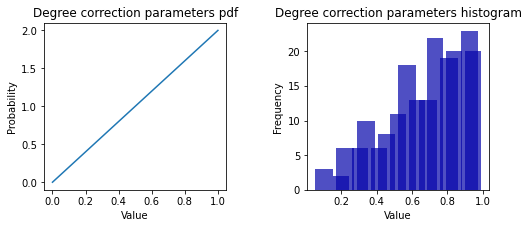

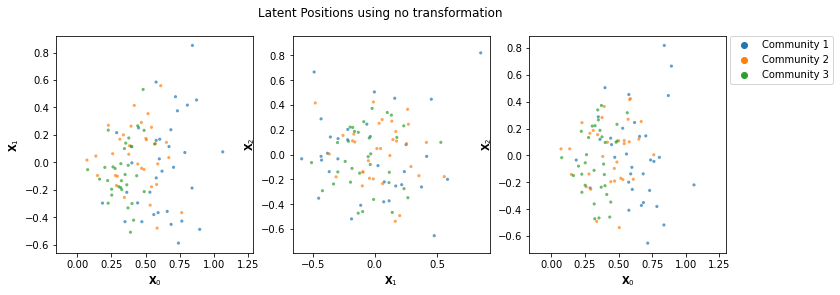

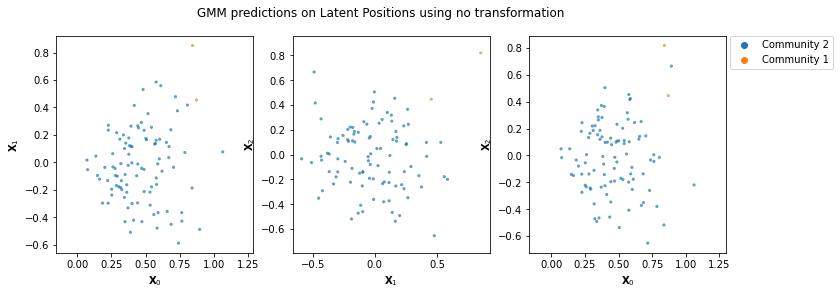

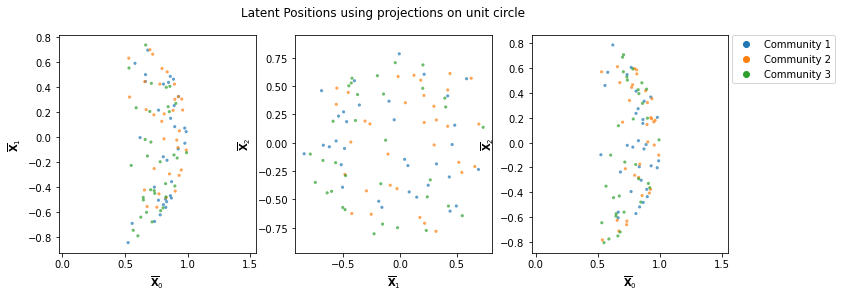

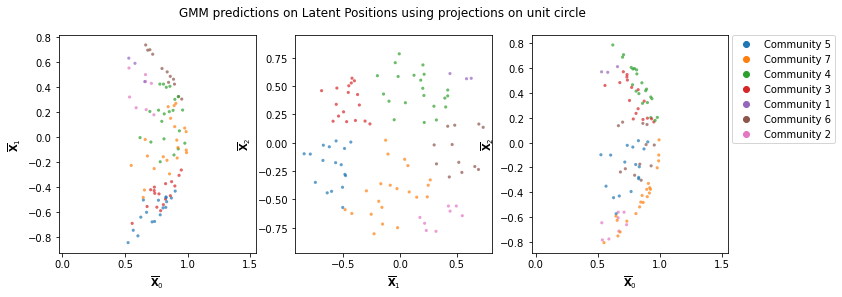

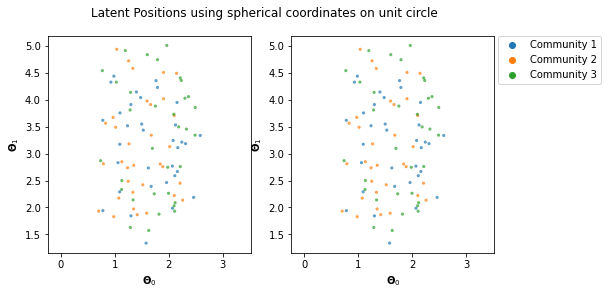

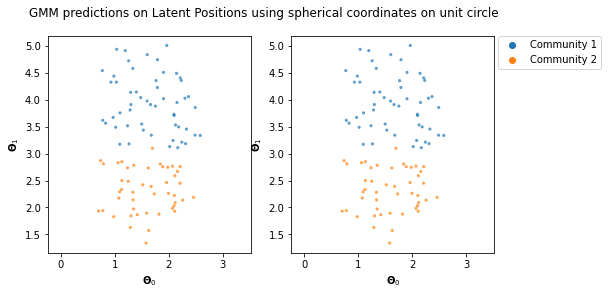

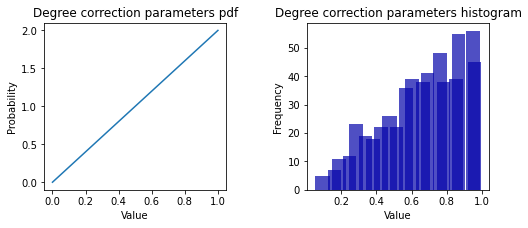

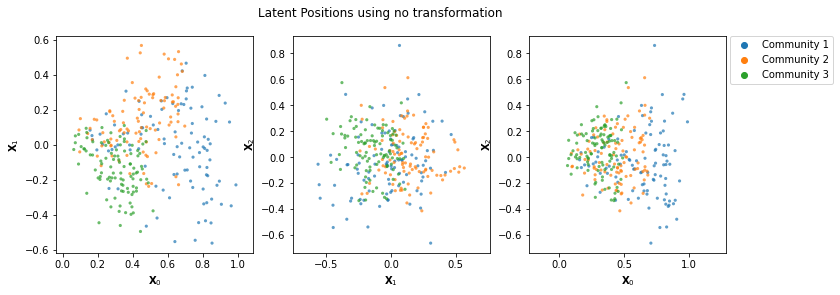

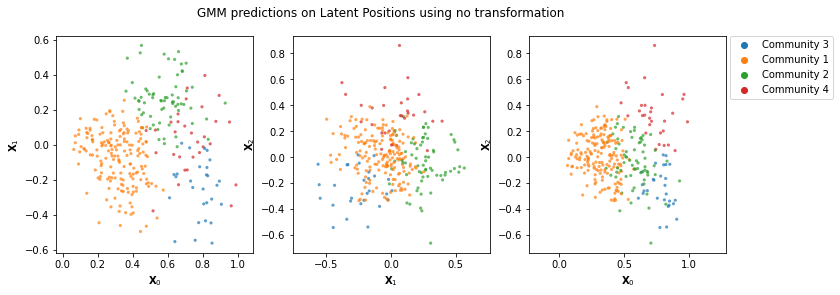

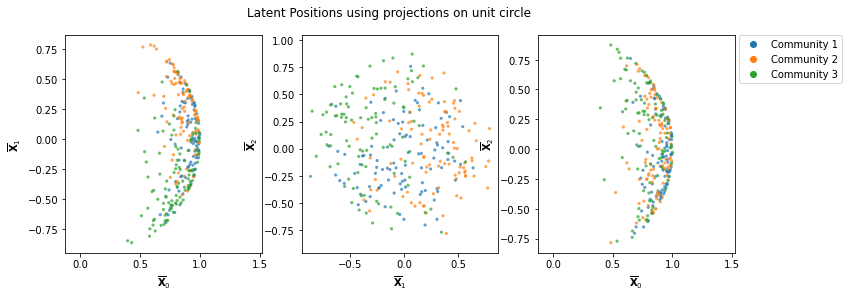

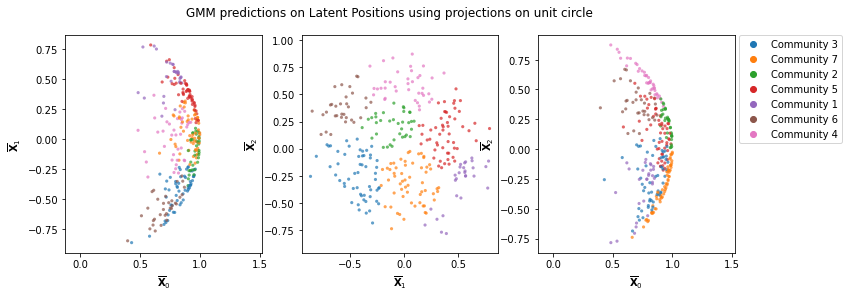

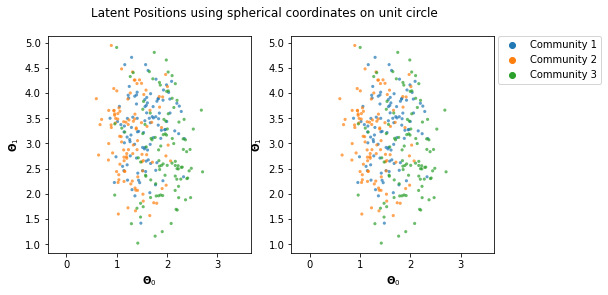

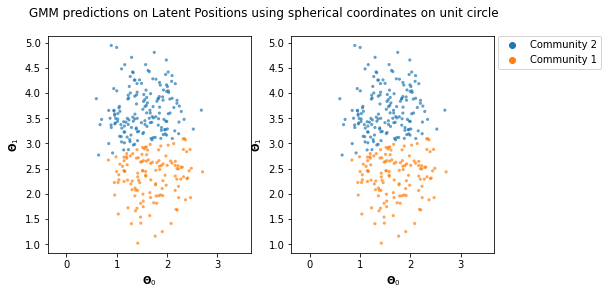

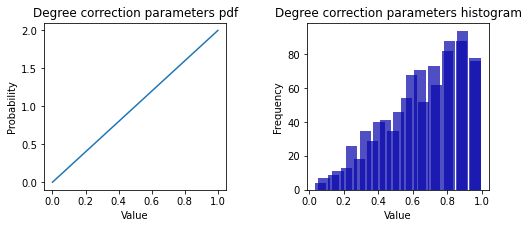

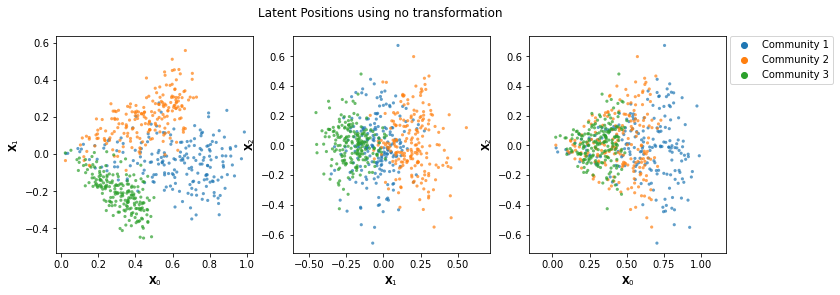

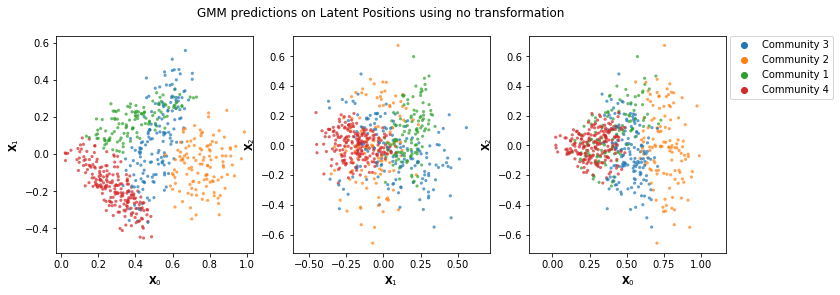

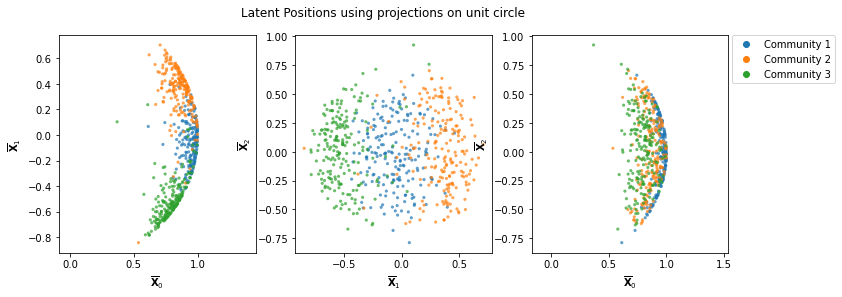

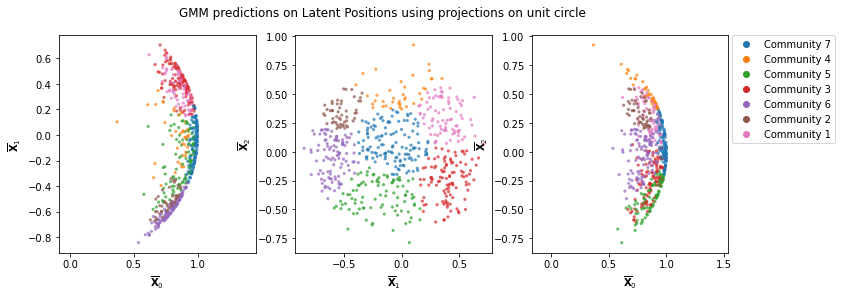

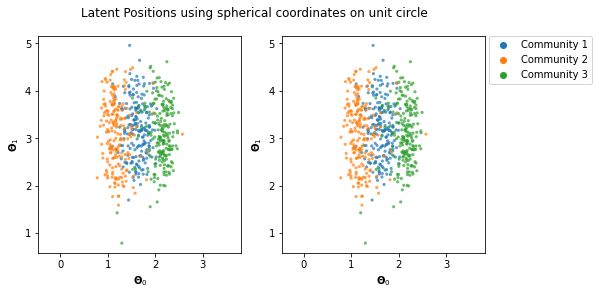

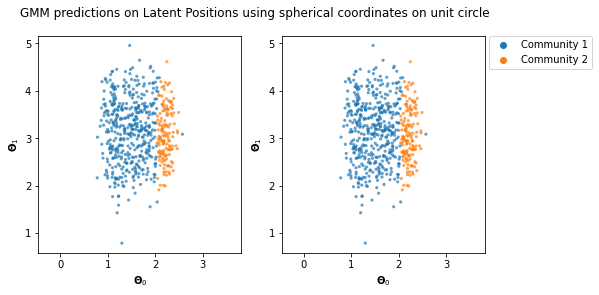

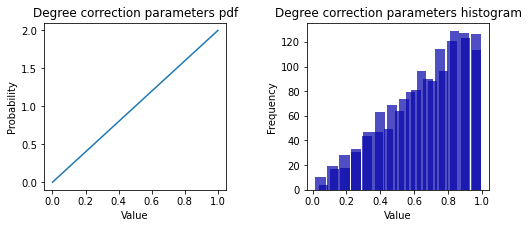

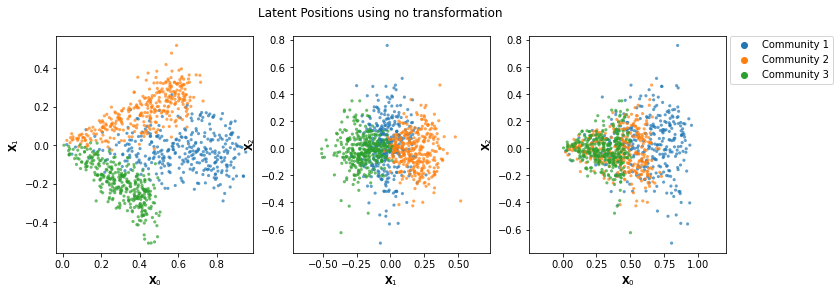

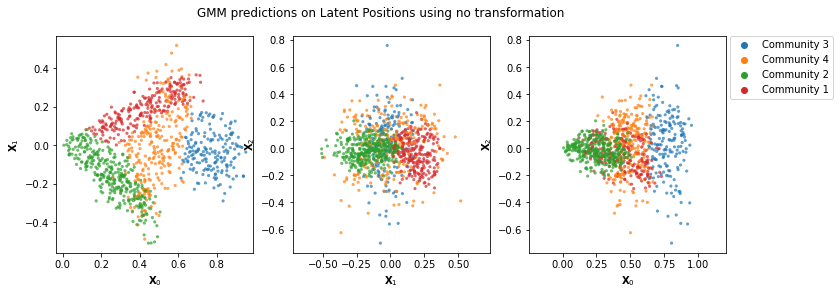

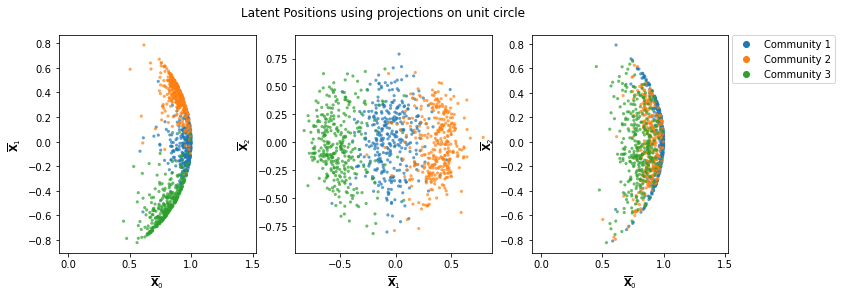

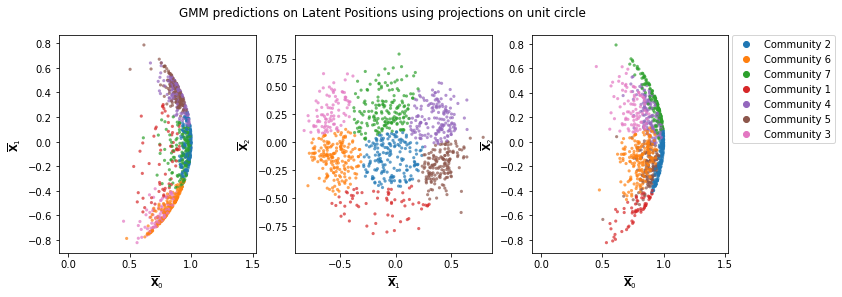

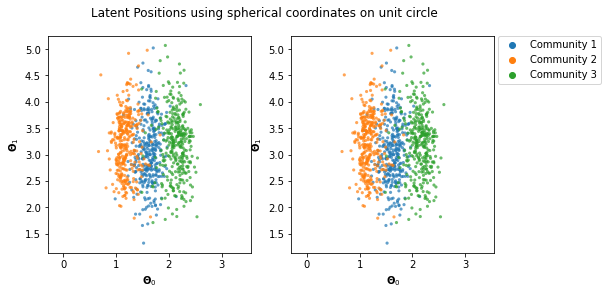

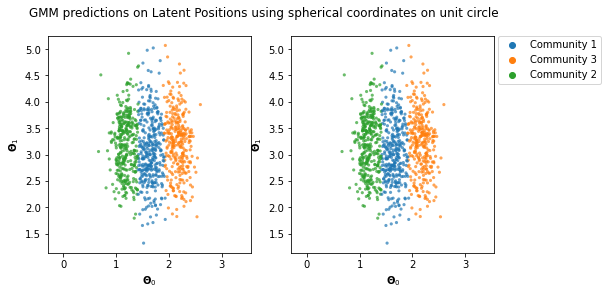

In [7]:
n_nodes = (100, 300, 600, 1000)
n_coms = []
aris_sparse = []
for n in n_nodes:
  B = np.vstack(([0.8, 0.6, 0.45],
                 [0.6, 0.5, 0.2],
                 [0.45, 0.2, 0.3]))
  
  n_com, aris = compare_ARIs(B,n=n, M_sim = 5)
  n_coms.append(n_com)
  aris_sparse.append(aris)

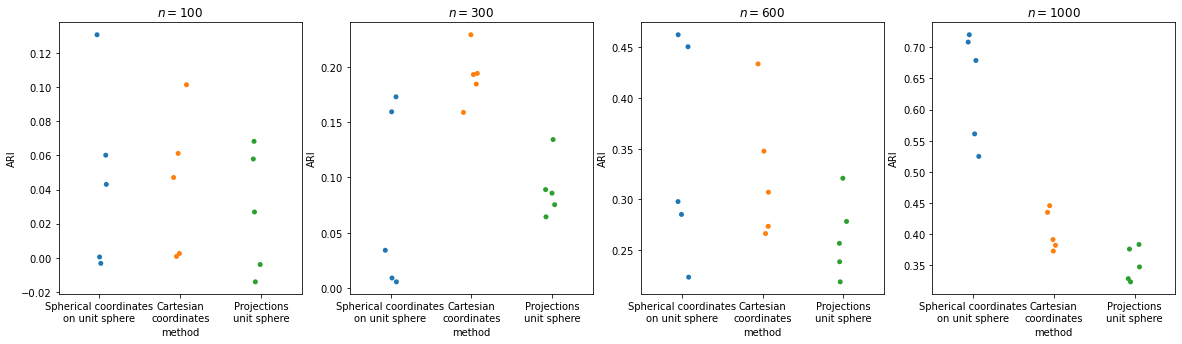

In [9]:
scale = 5

fig, ax = plt.subplots(1, 4, figsize=(scale * 4, scale * 1))

for i in range(4):
  ari_com_1000, ari_com_norm_1000, ari_com_theta_1000 = aris_sparse[i][0], aris_sparse[i][1], aris_sparse[i][2]

  ARI = {"ARI": ari_com_1000, "method": "Cartesian\ncoordinates", "Simulation Number": range(1,len(ari_com_1000)+1)}
  ARI_norm =  {"ARI": ari_com_norm_1000, "method": "Projections\nunit sphere", "Simulation Number": range(1,len(ari_com_norm_1000)+1)}
  ARI_theta = { "ARI": ari_com_theta_1000, "method": "Spherical coordinates\non unit sphere","Simulation Number": range(1,len(ari_com_theta_1000)+1)}

  ARI = pd.DataFrame(data=ARI)
  ARI_norm = pd.DataFrame(data=ARI_norm)
  ARI_theta = pd.DataFrame(data=ARI_theta)
  ARI = pd.concat([ARI_theta, ARI, ARI_norm], axis=0)

  ax[i] = sns.stripplot(x="method", y="ARI", data=ARI, ax=ax[i])
  ax[i].set(title=r"$n = "+str(n_nodes[i])+"$")

In [ ]:
n_nodes = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
n_coms = []
aris_n = []
for n in n_nodes:
  B = np.vstack(([0.8, 0.6, 0.45],
                 [0.6, 0.5, 0.2],
                 [0.45, 0.2, 0.3]))
  
  n_com, aris = compare_ARIs(B,n=n, M_sim = 5)
  n_coms.append(n_com)
  aris_n.append(aris)

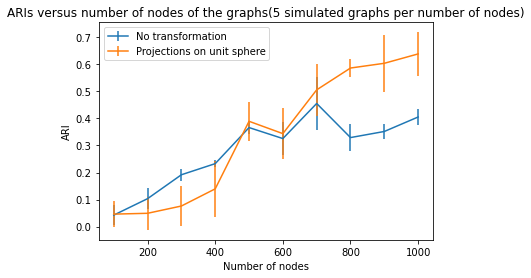

In [29]:
aris_n = np.array(aris_n)
ari_means = np.mean(aris_n, 2)
ari_stds = np.std(aris_n, 2)
fig, ax = plt.subplots()
ax.errorbar(n_nodes, ari_means[:, 0], yerr=ari_stds[:, 0])
ax.errorbar(n_nodes, ari_means[:, 2], yerr=ari_stds[:, 2])
ax.legend(['No transformation', 'Projections on unit sphere'])
ax.set_title('ARIs versus number of nodes of the graphs(5 simulated graphs per number of nodes)')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('ARI')
plt.show()